In [26]:
!pip3 install matplotlib numpy scipy pandas
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

In [27]:
# define constants

A = 1
Om = 3
T0 = 0.2
XMIN = 0
XMAX = 4

ATMAX = 10
ANMAX = 6
VMAX = 1.5

In [28]:
x = np.linspace(XMIN, XMAX, 1000)
y = lambda x: A * np.sin(Om * x + T0)
dy = lambda x: A * Om * np.cos(Om * x + T0)
ddy = lambda x: -A * Om * Om * np.sin(Om * x + T0)

from scipy.integrate import quad

sigma = np.array([quad(lambda x: np.sqrt(1 + (dy(x)) ** 2), XMIN, x)[0] for x in x])
dsigma = np.gradient(sigma, x)
ddsigma = np.gradient(dsigma, x)

curvature = np.abs(ddy(x)) / ((1 + dy(x) ** 2) ** (3 / 2))


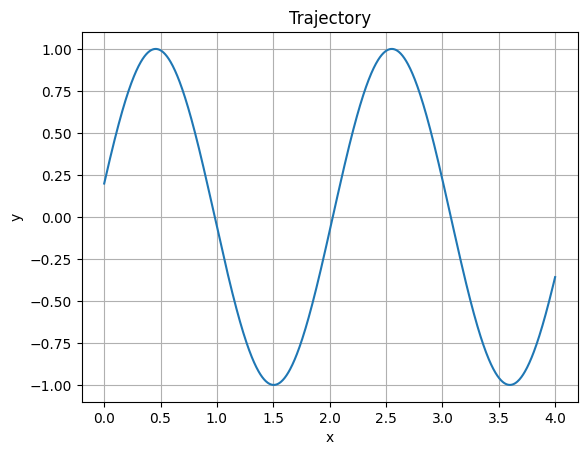

In [46]:
# draw trajectory on a plane

plt.grid()

plt.plot(x, y(x))
plt.xlabel("x")
plt.ylabel("y")
plt.title("Trajectory")
plt.savefig("trajectory.png")

8.72824057216428

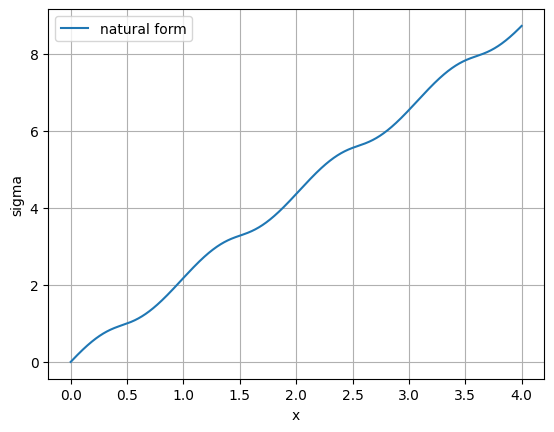

In [30]:
# show sigma by x

plt.grid()
plt.plot(x, sigma, label="natural form")
plt.xlabel("x")
plt.ylabel("sigma")

plt.legend()

sigma[-1]


Text(0.5, 1.0, 'Curvature')

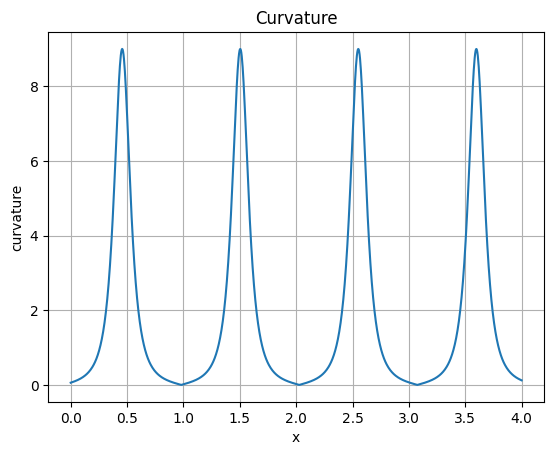

In [47]:
# let's find what is curvature at the each x

plt.grid()
plt.plot(x, curvature)
plt.xlabel("x")
plt.ylabel("curvature")
plt.title("Curvature")

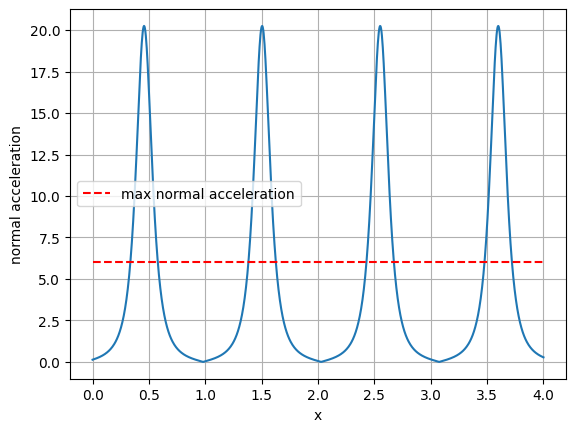

In [32]:
# imagine we move with constant speed all the time
# set constraints by normal acceleration depending the curvature

plt.grid()
plt.plot(x, curvature * VMAX**2)
plt.hlines(
    ANMAX,
    XMIN,
    XMAX,
    colors="red",
    linestyles="dashed",
    label="max normal acceleration",
)
plt.xlabel("x")
plt.ylabel("normal acceleration")
plt.legend()

plt.savefig("normal_acceleration_lim.png")

Text(0.5, 1.0, 'Normal acceleration')

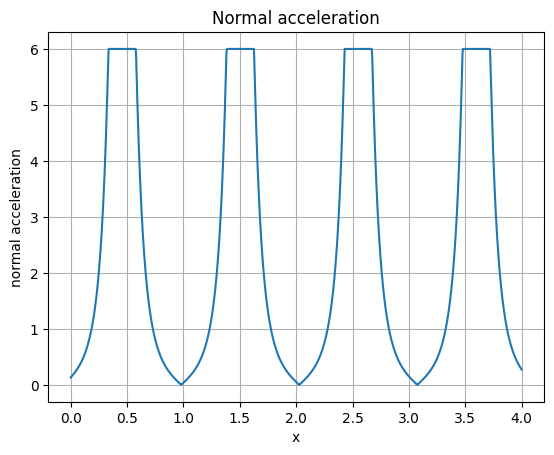

In [48]:
# set maximum available normal acceleration

accnmax = np.clip(curvature * VMAX**2, a_min=None, a_max=ANMAX)

plt.grid()
plt.plot(x, accnmax)
plt.xlabel("x")
plt.ylabel("normal acceleration")
plt.title("Normal acceleration")


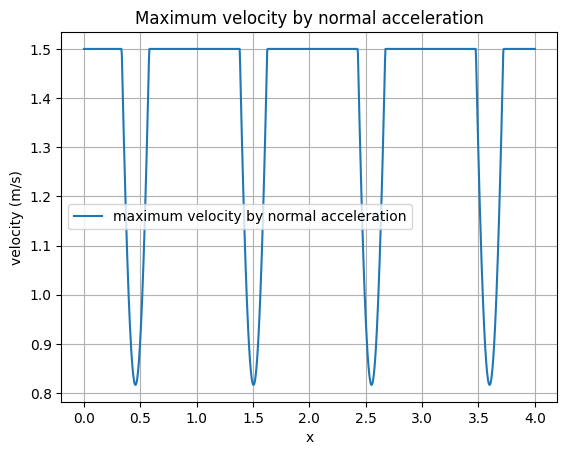

In [49]:
# compute maximum available velocity through the each point depending the normal acceleration

vmax_n = np.sqrt(accnmax / curvature)

plt.grid()
plt.plot(x, vmax_n, label="maximum velocity by normal acceleration")

plt.xlabel("x")
plt.ylabel("velocity (m/s)")
plt.title("Maximum velocity by normal acceleration")

plt.legend()
plt.savefig("velocity_by_normal_acceleration.png")

too fast change of velocity v1: 1.43741824924145 v2: 1.4775780351468113 dv: 0.039241617741633254
too fast change of velocity v1: 1.416252607527908 v2: 1.4558619132742612 dv: 0.03946596917797426
too fast change of velocity v1: 1.4557185767058822 v2: 1.4964909866973604 dv: 0.03904943457539516
too fast change of velocity v1: 1.4344404892029603 v2: 1.4745236151943928 dv: 0.03927293240433766
too fast change of velocity v1: 1.41331663578711 v2: 1.4528485343139277 dv: 0.03949741936318227
too fast change of velocity v1: 1.4528140551502924 v2: 1.493401573995177 dv: 0.03908062753719548


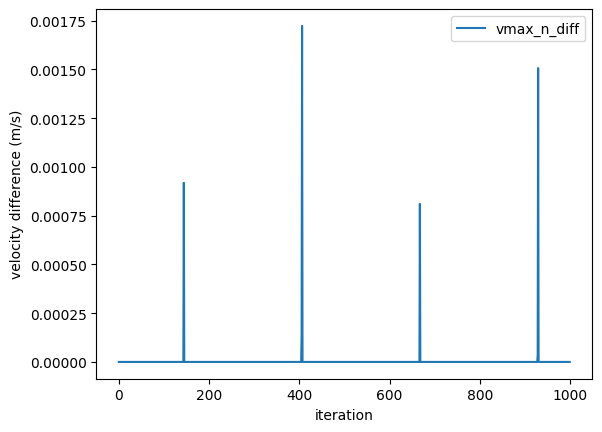

In [36]:
# validate that we do not change velocity too fast


dx_sigmas = []

dvmax_n = np.gradient(vmax_n, x)

vmax = [vmax_n[0]]

for i0, i1 in zip(range(len(vmax_n) - 1), range(1, len(vmax_n))):
    dx_sigma = np.sqrt(1 + dy(x[i0]) ** 2)
    dx_vmax_n = dvmax_n[i0]
    dx = x[i1] - x[i0]

    max_dv = ATMAX * dx_sigma * dx / np.average([vmax_n[i0], vmax_n[i1]])
    if vmax[-1] + max_dv < vmax_n[i1]:
        print(
            f"too fast change of velocity v1: {vmax[-1]} v2: {vmax_n[i1]} dv: {max_dv}"
        )
        vmax.append(np.minimum(vmax[-1] + max_dv, vmax_n[i1]))
    else:
        vmax.append(vmax_n[i1])

    dx_sigmas.append(dx_sigma)

vmax = np.array(vmax)

pd.DataFrame(data={"vmax_n_diff": vmax_n - vmax}).plot()
plt.xlabel("iteration")
plt.ylabel("velocity difference (m/s)")

plt.savefig("veldiff.png")


(-9.98160051699054, 9.812433606684351)

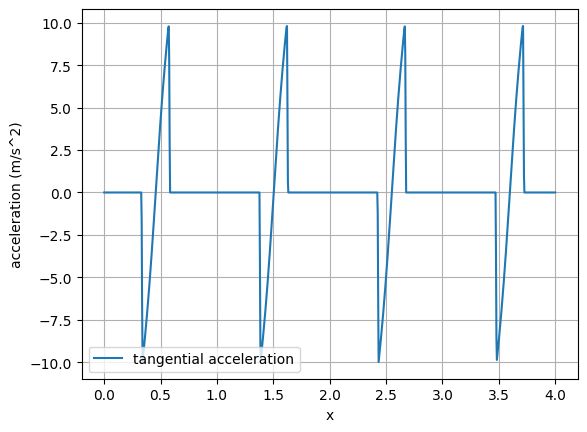

In [50]:
# compute tangential acceleration needed for velocity

acct = np.gradient(vmax, x)

plt.grid()
plt.plot(x, acct, label="tangential acceleration")
plt.xlabel("x")
plt.ylabel("acceleration (m/s^2)")
plt.legend()

plt.savefig("acctan_x.png")
np.min(acct), np.max(acct)

x to start deceleration 3.961079815158839


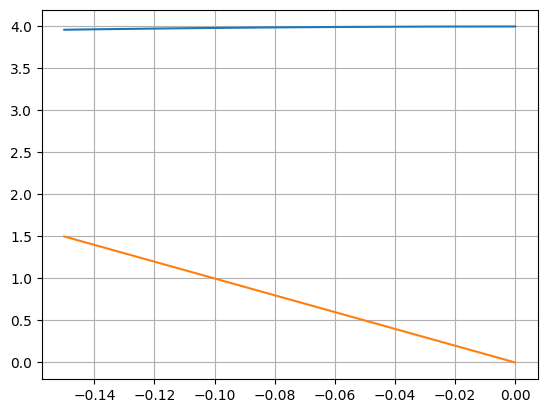

In [51]:
# estimate deceleration

xs = [XMAX]
time = [0]
vs = [0]

dt = 0.001
while vs[-1] < VMAX:
    last_x = xs[-1]
    last_v = vs[-1]

    dv = ATMAX * dt
    v = last_v + dv
    vs.append(v)

    time.append(time[-1] - dt)
    xs.append(last_x - v * dt / np.sqrt(1 + dy(last_x) ** 2))

plt.grid()
plt.plot(time, xs, label="trajectory")
plt.plot(time, vs, label="velocity")

TIME_DEC = xs[-1]
print(f"x to start deceleration {TIME_DEC}")

the last time 6.30500000000044


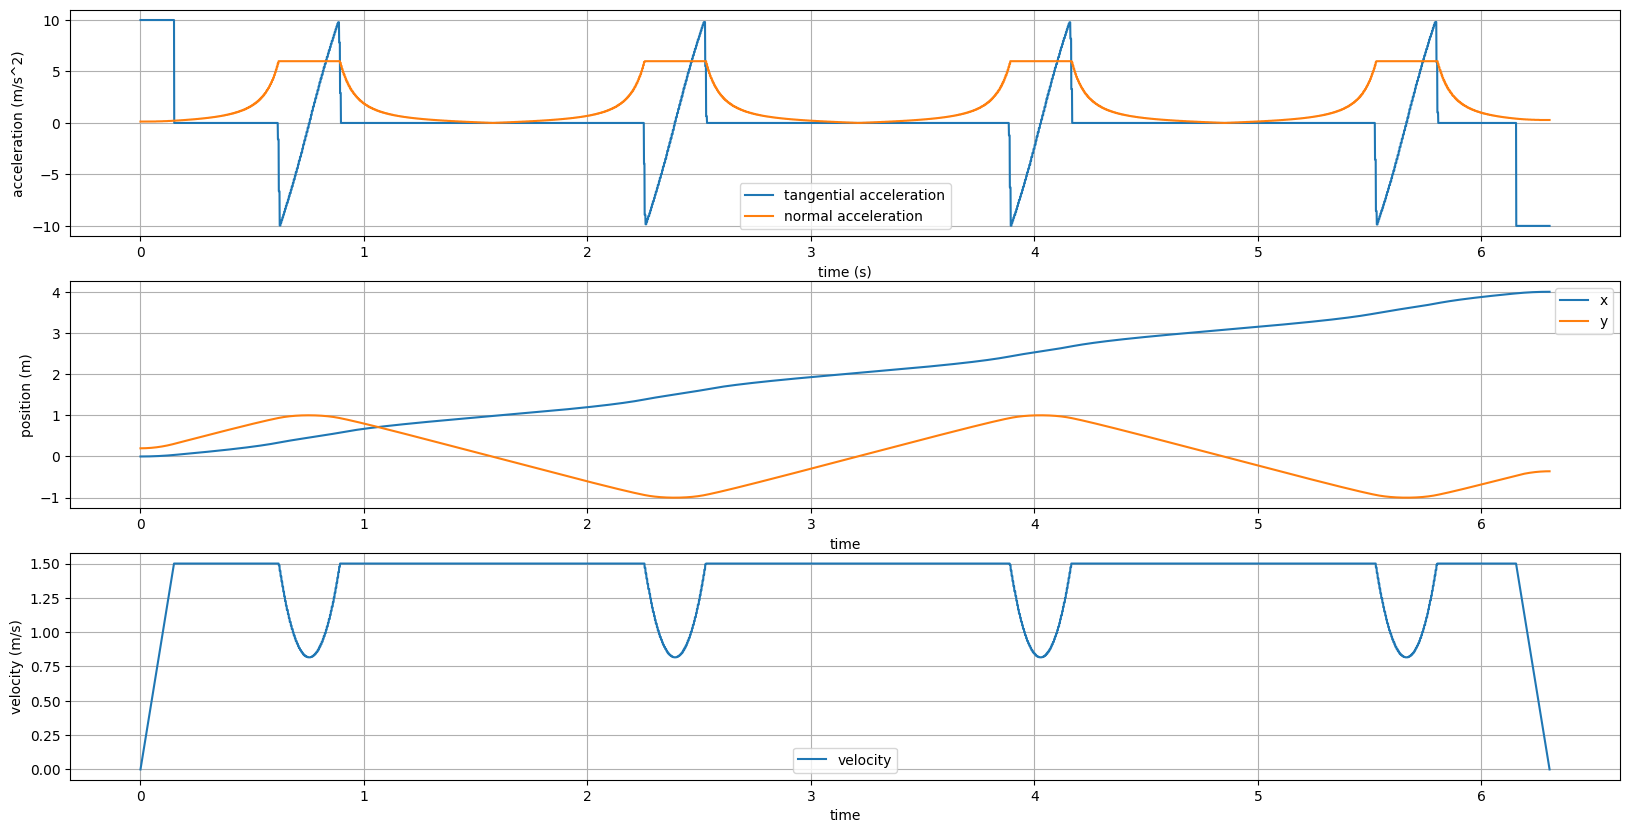

In [53]:
from dataclasses import dataclass
from typing import Optional


@dataclass
class Trace:
    a_tan: float
    v: float
    dt: float
    t: float
    prev: "Trace" = None

    last_x_val: Optional[float] = None

    @property
    def vc(self):
        return np.clip(self.v, 0, VMAX)

    @property
    def last_x(self):
        if self.last_x_val:
            return self.last_x_val

        if self.prev is None:
            return 0
        self.last_x_val = self.prev.x

        return self.last_x_val

    @property
    def dx(self):
        return self.v * self.dt / np.sqrt(1 + dy(self.last_x) ** 2)

    @property
    def x(self):
        return np.clip(self.last_x + self.dx, XMIN, XMAX)

    @property
    def curvature(self):
        return curvature[int(self.x / XMAX * (len(curvature) - 1))]
        return np.abs(ddy(self.x)) / (1 + dy(self.x) ** 2) ** (3 / 2)

    @property
    def a_norm(self):
        return accnmax[int(self.x / XMAX * (len(accnmax) - 1))]
        return self.curvature * self.v**2
        return np.clip(self.v**2 * self.curvature, -ANMAX, ANMAX)

    @property
    def y(self):
        return y(self.x)


traces = [Trace(ATMAX, 0, 0, 0, None)]


dt = 0.001
# for i, v in enumerate(v_int[:-1]):
while traces[-1].v <= VMAX:
    new = Trace(ATMAX, traces[-1].v + ATMAX * dt, dt, traces[-1].t + dt, traces[-1])
    traces.append(new)

while traces[-1].x < TIME_DEC:
    last_x = traces[-1].x

    at = acct[int(last_x / x[-1] * len(x))]
    v = vmax[int(last_x / x[-1] * len(x))]

    new = Trace(at, v, dt, traces[-1].t + dt, traces[-1])
    traces.append(new)

# we decelerate

while traces[-1].v > 0:
    new = Trace(-ATMAX, traces[-1].v - ATMAX * dt, dt, traces[-1].t + dt, traces[-1])
    traces.append(new)

time = [t.t for t in traces]
ats = [t.a_tan for t in traces]
ans = [t.a_norm for t in traces]
vel = [t.vc for t in traces]
xpos = [t.x for t in traces]
ypos = [t.y for t in traces]

fig, axs = plt.subplots(3, 1, figsize=(20, 10))

axs[0].grid()
axs[0].plot(time, ats, label="tangential acceleration")
axs[0].plot(time, ans, label="normal acceleration")
axs[0].set_xlabel("time (s)")
axs[0].set_ylabel("acceleration (m/s^2)")
axs[0].legend()

axs[1].grid()
axs[1].plot(time, xpos, label="x")
axs[1].plot(time, ypos, label="y")
axs[1].legend()
axs[1].set_xlabel("time (s)")
axs[1].set_ylabel("position (m)")
axs[1].set_xlabel("time")

axs[2].grid()
axs[2].plot(time, vel, label="velocity")
axs[2].legend()
axs[2].set_xlabel("time")
axs[2].set_ylabel("velocity (m/s)")

print(f"the last time {time[-1]}")

plt.savefig("result.png")
